In [1]:
# ==========================================
# 1. SETUP & DATA LOADING
# ==========================================
# Importing libraries for data manipulation (pandas) and visualization (seaborn/matplotlib)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setting visual style to make charts look professional
sns.set_style("whitegrid")

# Load the raw datasets
# Note: HBO data was sourced from Kaggle to represent the Warner Bros library
netflix = pd.read_csv('netflix_titles.csv')
hbo = pd.read_csv('HBO_MAX_Content.csv')

print(f"Data Loaded successfully. Netflix: {netflix.shape[0]} titles, HBO Max: {hbo.shape[0]} titles.")

Data Loaded successfully. Netflix: 8807 titles, HBO Max: 2087 titles.


In [3]:
# ==========================================
# 2. DATA NORMALIZATION STRATEGY
# ==========================================
# Netflix and HBO use different naming conventions (e.g., "Science Fiction" vs "Sci-Fi").
# To compare them fairly, we map them to a standardized list of 'Master Genres'.

# Netflix Mapping: Grouping sub-genres into macro categories
netflix_genre_map = {
    'Action & Adventure': 'Action', 'TV Action & Adventure': 'Action',
    'Comedies': 'Comedy', 'TV Comedies': 'Comedy', 'Stand-Up Comedy': 'Comedy',
    'Dramas': 'Drama', 'TV Dramas': 'Drama',
    'International Movies': 'International', 'International TV Shows': 'International',
    'Documentaries': 'Documentary', 'Docuseries': 'Documentary',
    'Horror Movies': 'Horror', 'TV Horror': 'Horror',
    'Sci-Fi & Fantasy': 'Sci-Fi', 'TV Sci-Fi & Fantasy': 'Sci-Fi',
    'Children & Family Movies': 'Kids', 'Kids\' TV': 'Kids',
    'Thrillers': 'Thriller', 'TV Thrillers': 'Thriller',
    'Romantic Movies': 'Romance', 'Romantic TV Shows': 'Romance',
    'Classic Movies': 'Classics'
}

# HBO Mapping: Aligning their specific columns to our Master Genres
hbo_genre_map = {
    'Action Adventure': 'Action', 'Comedy': 'Comedy', 'Drama': 'Drama',
    'Documentary': 'Documentary', 'Horror': 'Horror',
    'Science Fiction': 'Sci-Fi', 'Fantasy': 'Sci-Fi',
    'Children': 'Kids', 'Family': 'Kids',
    'Thriller': 'Thriller', 'Romance': 'Romance',
    'Animation': 'Animation', 'Anime': 'Animation'
}

In [4]:
# ==========================================
# 3. TRANSFORMATION: NETFLIX
# ==========================================
# Issue: Netflix stores genres as comma-separated strings (e.g., "Action, Drama").
# Solution: We use .explode() to separate these into distinct rows so we can count every genre tag.

netflix_clean = netflix.copy()
netflix_exploded = netflix_clean.assign(genre=netflix_clean['listed_in'].str.split(', ')).explode('genre')

# Apply the standardization map
netflix_exploded['std_genre'] = netflix_exploded['genre'].map(netflix_genre_map).fillna('Other')
netflix_exploded['Platform'] = 'Netflix'

# Keep only relevant columns for analysis
netflix_subset = netflix_exploded[['title', 'release_year', 'type', 'std_genre', 'Platform']]

In [5]:
# ==========================================
# 4. TRANSFORMATION: HBO MAX
# ==========================================
# Issue: HBO stores genres in "Wide Format" (separate columns for each genre with 0/1 values).
# Solution: We use .melt() to convert this to "Long Format" to match the Netflix structure.

# Identify genre columns
genre_cols = [c for c in hbo.columns if 'genres_' in c]

# Pivot from Wide to Long
hbo_melted = hbo.melt(id_vars=['title', 'year', 'type'],
                      value_vars=genre_cols,
                      var_name='raw_genre',
                      value_name='is_present')

# Filter for relevant rows and clean string names
hbo_melted = hbo_melted[hbo_melted['is_present'] == 1]
hbo_melted['genre_clean'] = hbo_melted['raw_genre'].str.replace('genres_', '').str.replace('_', ' ')

# Apply standardization
hbo_melted['std_genre'] = hbo_melted['genre_clean'].map(hbo_genre_map).fillna('Other')
hbo_melted['Platform'] = 'HBO Max'
hbo_melted.rename(columns={'year': 'release_year'}, inplace=True)

hbo_subset = hbo_melted[['title', 'release_year', 'type', 'std_genre', 'Platform']]

In [6]:
# Combine both dataframes
combined_df = pd.concat([netflix_subset, hbo_subset], ignore_index=True)

# Filter out "Other" to keep charts clean
combined_df = combined_df[combined_df['std_genre'] != 'Other']

# Save to CSV (Optional, but good for your records)
combined_df.to_csv('Netflix_HBO_Combined.csv', index=False)

print(f"Datasets merged! Total Rows: {len(combined_df)}")

Datasets merged! Total Rows: 20434


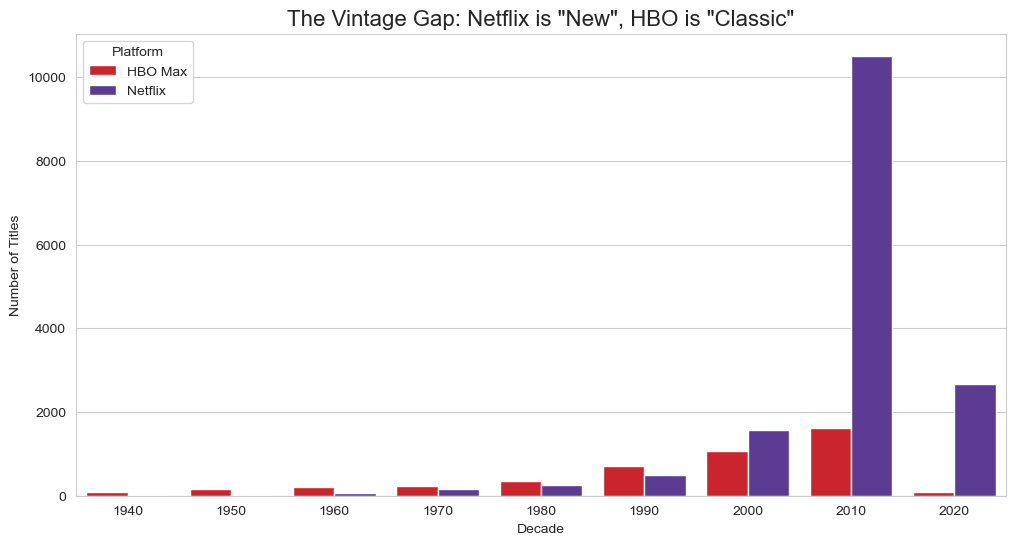

In [7]:
# ==========================================
# 5. STRATEGIC ANALYSIS: THE VINTAGE GAP
# ==========================================
# Hypothesis: Netflix relies on new releases (Recency Bias), while Warner Bros owns the classics.
# Method: Bin content by Decade and compare volume.

# Create Decade Bins
combined_df['Decade'] = (combined_df['release_year'] // 10) * 10
vintage_counts = combined_df.groupby(['Platform', 'Decade'])['title'].count().reset_index()
vintage_counts = vintage_counts[vintage_counts['Decade'] >= 1940]

# Visualize
plt.figure(figsize=(12, 6))
sns.barplot(data=vintage_counts, x='Decade', y='title', hue='Platform', palette=['#E50914', '#582CA1'])
plt.title('The Vintage Gap: Netflix is "New", HBO is "Classic"', fontsize=16)
plt.ylabel('Number of Titles')
plt.xlabel('Decade')
plt.legend(title='Platform')
plt.show()

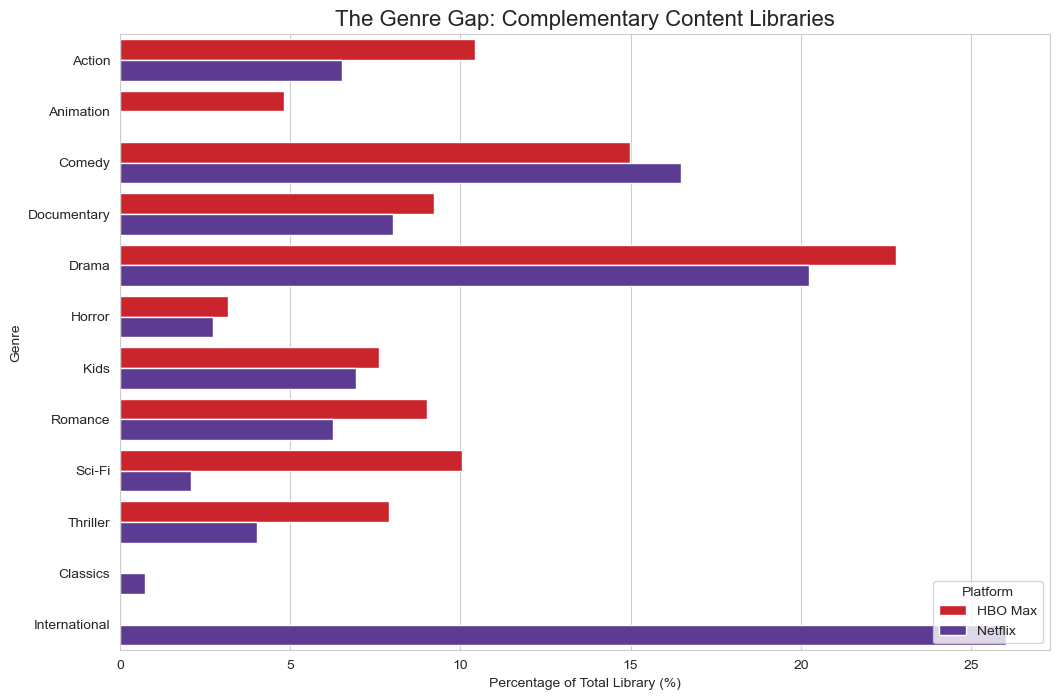

In [8]:
# ==========================================
# 6. STRATEGIC ANALYSIS: THE CONTENT SYNERGY
# ==========================================
# Hypothesis: The libraries are complementary (different strengths) rather than redundant.
# Method: Calculate the % share of total library dedicated to each genre.

# Calculate Percentage Composition
genre_counts = combined_df.groupby(['Platform', 'std_genre']).size().reset_index(name='count')
total_counts = combined_df.groupby('Platform').size().reset_index(name='total')
genre_stats = genre_counts.merge(total_counts, on='Platform')
genre_stats['percentage'] = (genre_stats['count'] / genre_stats['total']) * 100

# Visualize
plt.figure(figsize=(12, 8))
sns.barplot(data=genre_stats, x='percentage', y='std_genre', hue='Platform', palette=['#E50914', '#582CA1'])
plt.title('The Genre Gap: Complementary Content Libraries', fontsize=16)
plt.xlabel('Percentage of Total Library (%)')
plt.ylabel('Genre')
plt.legend(title='Platform', loc='lower right')
plt.show()